# Census Income Prediction using PySpark

The [Census-Income (KDD) Dataset](https://archive.ics.uci.edu/dataset/117/census+income+kdd) is a dataset containing census data extracted from 1994 to 1995 by the US Census Bureau. It contains 299285 instances.
The target of the project is to correctly predict the income binary variable, where the values are "above 50.000$" and "below 50.000$".

In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

spark = SparkSession.builder \
    .appName("Census Income Data Analysis") \
    .getOrCreate()

24/01/07 16:35:47 WARN Utils: Your hostname, francesco-PC resolves to a loopback address: 127.0.1.1; using 192.168.1.211 instead (on interface enp4s0)
24/01/07 16:35:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/07 16:35:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Load data
The dataset is already split into train and test. After defining the schema of the dataset, I will proceed to define the categorical variables within the dataset.

In [2]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType

schema = StructType([
    StructField('age',IntegerType(), True),
    StructField('class_of_worker', StringType (), True),
    StructField('industry_code', DoubleType (), True),
    StructField('occupation_code', DoubleType (), True),
    StructField('education', StringType (), True),
    StructField('wage_per_hour', DoubleType (), True),
    StructField('enrolled_in_edu_inst_last_wk', StringType (), True),
    StructField('marital_status', StringType (), True),
    StructField('major_industry_code', StringType (), True),
    StructField('major_occupation_code', StringType (), True),
    StructField('race', StringType (), True),
    StructField('hispanic_Origin', StringType (), True),
    StructField('sex', StringType (), True),
    StructField('member_of_a_labor_union', StringType (), True),
    StructField('reason_for_unemployment', StringType (), True),
    StructField('full_or_part_time_employment_stat', StringType (), True),
    StructField('capital_gains', DoubleType (), True),
    StructField('capital_losses', DoubleType (), True),
    StructField('divdends_from_stocks', DoubleType (), True),
    StructField('tax_filer_status', StringType (), True),
    StructField('region_of_previous_residence', StringType (), True),
    StructField('state_of_previous_residence', StringType (), True),
    StructField('detailed_household_and_family_stat', StringType (), True),
    StructField('detailed_household_summary_in_household', StringType (), True),
    StructField('instance_weight', DoubleType (), True),
    StructField('migration_code_change_in_msa', StringType (), True),
    StructField('migration_code_change_in_reg', StringType (), True),
    StructField('migration_code_move_within_reg', StringType (), True),
    StructField('live_in_this_house_1_year_ago', StringType (), True),
    StructField('migration_prev_res_in_sunbelt', StringType (), True),
    StructField('num_persons_worked_for_employer', DoubleType (), True),
    StructField('family_members_under_18', StringType (), True),
    StructField('country_of_birth_father', StringType (), True),
    StructField('country_of_birth_mother', StringType (), True),
    StructField('country_of_birth_self', StringType (), True),
    StructField('citizenship', StringType (), True),
    StructField('own_business_or_self_employed', DoubleType (), True),
    StructField('fill_inc_questionnaire_for_veterans_admin', StringType (), True),
    StructField('veterans_benefits', DoubleType (), True),
    StructField('weeks_worked_in_year', DoubleType (), True),
    StructField('year', DoubleType (), True),
    StructField('income', StringType (), True),
])


In [3]:
# Load the .data file
data_path = "data/census-income.data"
df_train = spark.read.csv(data_path, schema=schema, header=False)

# Load the .test file
test_path = "data/census-income.test"
df_test = spark.read.csv(test_path, schema=schema, header=False)

# drop instance weight column ( suggested in dataset notes)
df_train = df_train.drop('instance_weight')
df_test = df_test.drop('instancee_weight')

categorical_cols = ['class_of_worker', 'education','enrolled_in_edu_inst_last_wk','marital_status', 'major_industry_code', 'major_occupation_code','race', 'hispanic_Origin', 'sex', 'member_of_a_labor_union', 'reason_for_unemployment','full_or_part_time_employment_stat','tax_filer_status','region_of_previous_residence','state_of_previous_residence','detailed_household_and_family_stat', 'detailed_household_summary_in_household', 'migration_code_change_in_msa', 'migration_code_change_in_reg', 'migration_code_move_within_reg', 'live_in_this_house_1_year_ago', 'migration_prev_res_in_sunbelt','family_members_under_18','country_of_birth_father','country_of_birth_mother','country_of_birth_self','citizenship','fill_inc_questionnaire_for_veterans_admin']
numerical_cols = ['age', 'industry_code', 'occupation_code', 'wage_per_hour', 'capital_gains', 'capital_losses', 'divdends_from_stocks', 'num_persons_worked_for_employer', 'own_business_or_self_employed', 'veterans_benefits', 'weeks_worked_in_year', 'year']

# Print first 5 rows
df_train.show(5, truncate=False, vertical=True)

24/01/07 16:35:58 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


-RECORD 0------------------------------------------------------------------------------
 age                                       | 73                                        
 class_of_worker                           |  Not in universe                          
 industry_code                             | 0.0                                       
 occupation_code                           | 0.0                                       
 education                                 |  High school graduate                     
 wage_per_hour                             | 0.0                                       
 enrolled_in_edu_inst_last_wk              |  Not in universe                          
 marital_status                            |  Widowed                                  
 major_industry_code                       |  Not in universe or children              
 major_occupation_code                     |  Not in universe                          
 race                           

In [4]:
df_train.printSchema()

root
 |-- age: integer (nullable = true)
 |-- class_of_worker: string (nullable = true)
 |-- industry_code: double (nullable = true)
 |-- occupation_code: double (nullable = true)
 |-- education: string (nullable = true)
 |-- wage_per_hour: double (nullable = true)
 |-- enrolled_in_edu_inst_last_wk: string (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- major_industry_code: string (nullable = true)
 |-- major_occupation_code: string (nullable = true)
 |-- race: string (nullable = true)
 |-- hispanic_Origin: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- member_of_a_labor_union: string (nullable = true)
 |-- reason_for_unemployment: string (nullable = true)
 |-- full_or_part_time_employment_stat: string (nullable = true)
 |-- capital_gains: double (nullable = true)
 |-- capital_losses: double (nullable = true)
 |-- divdends_from_stocks: double (nullable = true)
 |-- tax_filer_status: string (nullable = true)
 |-- region_of_previous_residence: strin

In [5]:
print(f'The train dataset has {df_train.count()} rows and {len(df_train.columns)} columns')

The train dataset has 199523 rows and 41 columns


# Exploratory Data Analysis

For simplicity reasons, EDA visualization will be performed using a pandas dataframe instead of the sparks one

In [6]:
df_train_pd = df_train.toPandas()

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'industry_code'}>,
        <Axes: title={'center': 'occupation_code'}>],
       [<Axes: title={'center': 'wage_per_hour'}>,
        <Axes: title={'center': 'capital_gains'}>,
        <Axes: title={'center': 'capital_losses'}>],
       [<Axes: title={'center': 'divdends_from_stocks'}>,
        <Axes: title={'center': 'num_persons_worked_for_employer'}>,
        <Axes: title={'center': 'own_business_or_self_employed'}>],
       [<Axes: title={'center': 'veterans_benefits'}>,
        <Axes: title={'center': 'weeks_worked_in_year'}>,
        <Axes: title={'center': 'year'}>]], dtype=object)

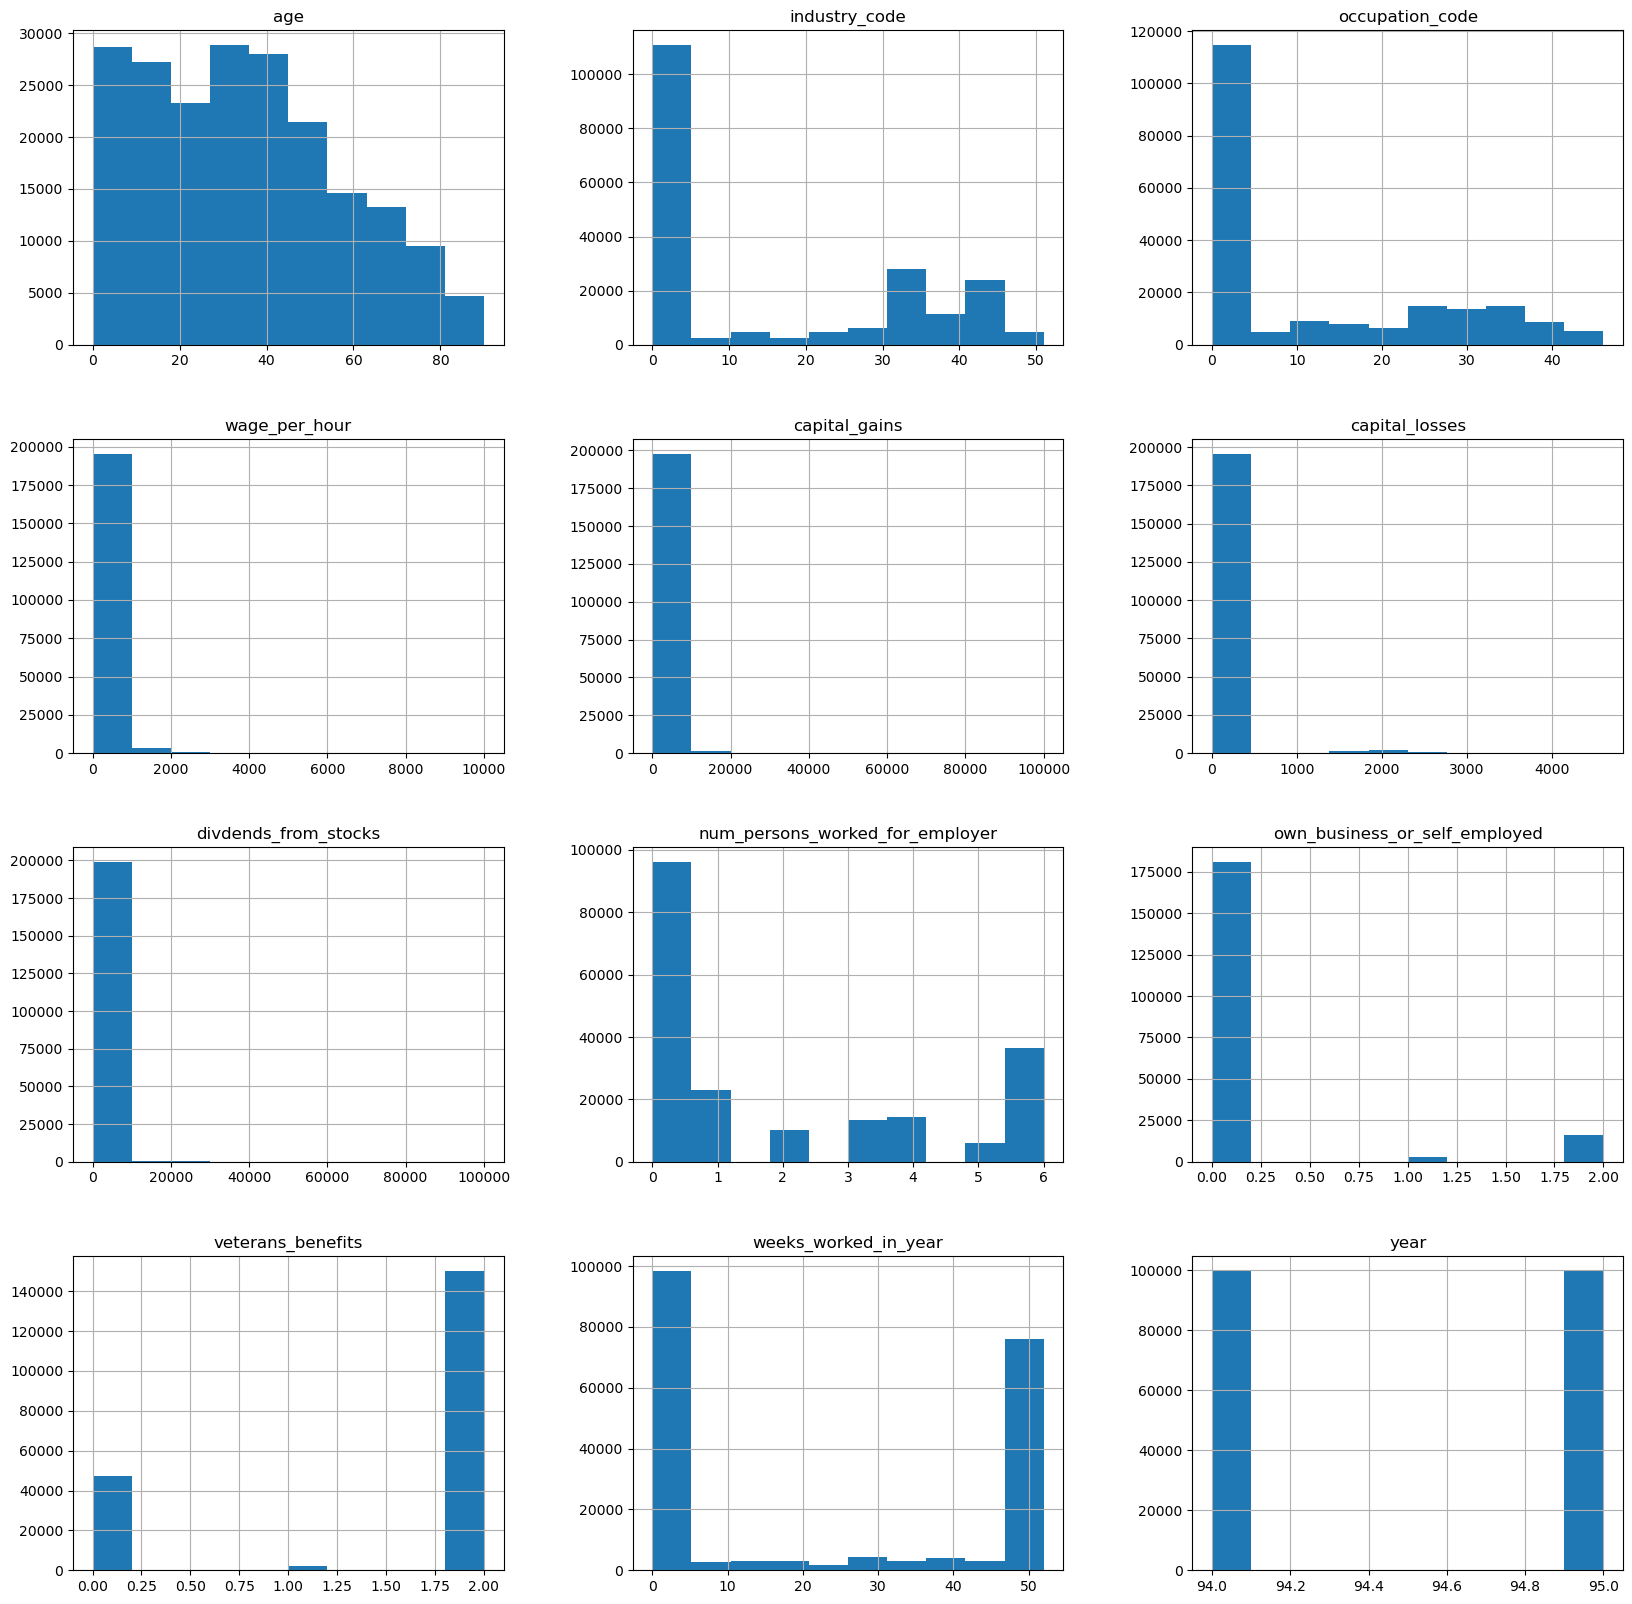

In [7]:
df_train_pd.hist(bins=10, figsize=(20,20))

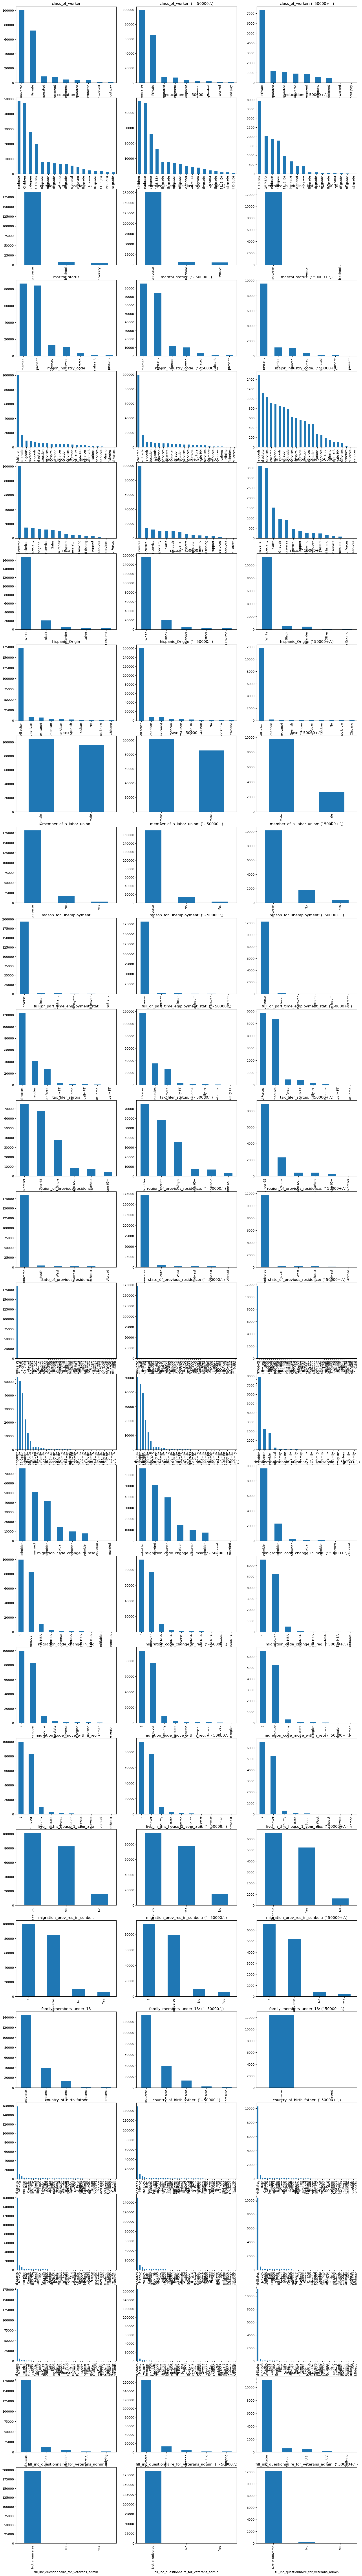

In [8]:
# get categorical and boolean features
cat_bool_col = [col[0] for col in df_train.dtypes if col[1] == 'string' and col[0] != 'income']

# group by values by outcome
train_set_pd_grouped = dict(list(df_train_pd.groupby(['income'])))
classes = list(train_set_pd_grouped.keys())

# create a one large plot
fig, ax = plt.subplots(len(cat_bool_col), 3, figsize=(20,150))

# for each variable add 3 plots
for num_var, var in enumerate(cat_bool_col):
    df_train_pd[var].value_counts().plot(kind="bar", ax=ax[num_var][0], title=var)
    for num_outcome, outcome in enumerate(classes):
        train_set_pd_grouped[outcome][var].value_counts().plot(kind="bar", ax=ax[num_var][1 + num_outcome], 
                                                               title='{}: {}'.format(var, outcome))

plt.show()

We can see how some of these variables have a high intra-class variance and not a high significance, for instance `hispanic_origin` or `reason_for_unemployment`. We will thus further clean the dataset.

In [9]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import IntegerType

mapping = {' - 50000.': '0',' 50000+.': '1'}


df_train = df_train.replace(to_replace=mapping, subset=['income'])
df_train = df_train.withColumn('income', df_train['income'].cast(IntegerType()))

df_test = df_test.replace(to_replace=mapping, subset=['income'])
df_test = df_test.withColumn('income', df_test['income'].cast(IntegerType()))

df_train.select('income').distinct().show()

+------+
|income|
+------+
|     1|
|     0|
+------+


## Dimensionality reduction
As the previous plots suggest, many variables are extremely unbalanced and don't provide much information. Two possible approaches to remove non-relevant variables are correlation with the target variable or PCA. Of course, none of the two is suited for categorical data, and as we saw the dataset contains a relevant number of categorical variables. Thus, we will use correlation for numerical data and manual selection for categorical columns, eventually after binning to more representative categories.

In [10]:
import pandas as pd
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

def correlation_matrix(df, corr_columns, method='pearson'):
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=corr_columns, outputCol=vector_col)
    df_vector = assembler.transform(df).select(vector_col)
    matrix = Correlation.corr(df_vector, vector_col, method)

    result = matrix.collect()[0]["pearson({})".format(vector_col)].values
    return pd.DataFrame(result.reshape(-1, len(corr_columns)), columns=corr_columns, index=corr_columns)

cm = correlation_matrix(df_train, numerical_cols + ['income'])
cm['income'].sort_values(ascending=False)

income                             1.000000
weeks_worked_in_year               0.262316
capital_gains                      0.240725
num_persons_worked_for_employer    0.222684
industry_code                      0.196190
divdends_from_stocks               0.175779
capital_losses                     0.147417
veterans_benefits                  0.140930
age                                0.135720
own_business_or_self_employed      0.040473
wage_per_hour                      0.024528
year                               0.014794
occupation_code                    0.013414
Name: income, dtype: float64

In [11]:
columns_to_drop = ['country_of_birth_father', 'country_of_birth_mother', 'citizenship', 'hispanic_Origin', 'fill_inc_questionnaire_for_veterans_admin', 'state_of_previous_residence', 'enrolled_in_edu_inst_last_wk', 'reason_for_unemployment', 'region_of_previous_residence']
df_train = df_train.drop(*columns_to_drop)
df_test = df_test.drop(*columns_to_drop)

for c in columns_to_drop:
    categorical_cols.remove(c)
    
categorical_cols

['class_of_worker',
 'education',
 'marital_status',
 'major_industry_code',
 'major_occupation_code',
 'race',
 'sex',
 'member_of_a_labor_union',
 'full_or_part_time_employment_stat',
 'tax_filer_status',
 'detailed_household_and_family_stat',
 'detailed_household_summary_in_household',
 'migration_code_change_in_msa',
 'migration_code_change_in_reg',
 'migration_code_move_within_reg',
 'live_in_this_house_1_year_ago',
 'migration_prev_res_in_sunbelt',
 'family_members_under_18',
 'country_of_birth_self']

In [12]:
mappings = dict()

In [13]:
df_train.select('education').distinct().show(truncate=False)

+---------------------------------------+
|education                              |
+---------------------------------------+
| 10th grade                            |
| Some college but no degree            |
| Doctorate degree(PhD EdD)             |
| Less than 1st grade                   |
| 12th grade no diploma                 |
| Associates degree-academic program    |
| Bachelors degree(BA AB BS)            |
| High school graduate                  |
| Prof school degree (MD DDS DVM LLB JD)|
| 9th grade                             |
| Associates degree-occup /vocational   |
| 11th grade                            |
| Children                              |
| Masters degree(MA MS MEng MEd MSW MBA)|
| 5th or 6th grade                      |
| 1st 2nd 3rd or 4th grade              |
| 7th and 8th grade                     |
+---------------------------------------+


In [14]:
mappings['education'] = {
    '10th grade': 'no_diploma',
    'Some college but no degree': 'diploma',
    'Doctorate degree(PhD EdD)': 'phd',
    'Less than 1st grade': 'no_diploma',
    '12th grade no diploma': 'no_diploma',
    'Associates degree-academic program': 'degree',
    'Bachelors degree(BA AB BS)': 'degree',
    'High school graduate': 'diploma',
    'Prof school degree (MD DDS DVM LLB JD)': 'degree',
    '9th grade': 'no_diploma',
    'Associates degree-occup /vocational': 'degree',
    '11th grade': 'no_diploma',
    'Children': 'no_diploma',
    'Masters degree(MA MS MEng MEd MSW MBA)': 'degree',
    '5th or 6th grade': 'no_diploma',
    '1st 2nd 3rd or 4th grade': 'no_diploma',
    '7th and 8th grade': 'no_diploma',
}

In [15]:
df_train.select('country_of_birth_self').distinct().show(truncate=False, n = 50)

+-----------------------------+
|country_of_birth_self        |
+-----------------------------+
| Dominican-Republic          |
| Ireland                     |
| Cuba                        |
| Guatemala                   |
| Iran                        |
| Panama                      |
| El-Salvador                 |
| Taiwan                      |
| Hong Kong                   |
| United-States               |
| Japan                       |
| Nicaragua                   |
| Canada                      |
| Cambodia                    |
| Laos                        |
| Germany                     |
| South Korea                 |
| Trinadad&Tobago             |
| Peru                        |
| Ecuador                     |
| Yugoslavia                  |
| Vietnam                     |
| Philippines                 |
| Honduras                    |
| Jamaica                     |
| England                     |
| India                       |
| Puerto-Rico                 |
| Holand

In [16]:
mappings['country_of_birth_self'] = {
    'Dominican-Republic': 'CAM',
    'Trinadad&Tobago': 'CAM',
    'Ireland': 'EU',
    'England': 'EU',
    'Poland': 'EU',
    'Scotland': 'EU',
    'Hungary': 'EU',
    'France': 'EU',
    'Germany': 'EU',
    'Portugal': 'EU',
    'Holand-Netherlands': 'EU',
    'Greece': 'EU',
    'Yugoslavia': 'EU',
    'Italy': 'EU',
    'Cuba': 'CAM',
    'Haiti': 'CAM',
    'Honduras': 'CAM',
    'Nicaragua': 'CAM',
    'Mexico': 'CAM',
    'Jamaica': 'CAM',
    'Puerto-Rico': 'CAM',
    'Guatemala': 'CAM',
    'Iran': 'AS',
    'Vietnam': 'AS',
    'Thailand': 'AS',
    'China': 'AS',
    'India': 'AS',
    'Japan': 'AS',
    'Cambodia': 'AS',
    'Philippines': 'AS',
    'Laos': 'AS',
    'Hong Kong': 'AS',
    'Taiwan': 'AS',
    'Outlying-U S (Guam USVI etc)': 'OC',
    'South Korea': 'AS',
    'Panama': 'CAM',
    'El-Salvador': 'CAM',
    'United-States': 'NAM',
    'Canada': 'NAM',
    'Peru': 'SAM',
    'Ecuador': 'SAM',
    'Columbia': 'SAM',
}

In [17]:
mappings

{'education': {'10th grade': 'no_diploma',
  'Some college but no degree': 'diploma',
  'Doctorate degree(PhD EdD)': 'phd',
  'Less than 1st grade': 'no_diploma',
  '12th grade no diploma': 'no_diploma',
  'Associates degree-academic program': 'degree',
  'Bachelors degree(BA AB BS)': 'degree',
  'High school graduate': 'diploma',
  'Prof school degree (MD DDS DVM LLB JD)': 'degree',
  '9th grade': 'no_diploma',
  'Associates degree-occup /vocational': 'degree',
  '11th grade': 'no_diploma',
  'Children': 'no_diploma',
  'Masters degree(MA MS MEng MEd MSW MBA)': 'degree',
  '5th or 6th grade': 'no_diploma',
  '1st 2nd 3rd or 4th grade': 'no_diploma',
  '7th and 8th grade': 'no_diploma'},
 'country_of_birth_self': {'Dominican-Republic': 'CAM',
  'Trinadad&Tobago': 'CAM',
  'Ireland': 'EU',
  'England': 'EU',
  'Poland': 'EU',
  'Scotland': 'EU',
  'Hungary': 'EU',
  'France': 'EU',
  'Germany': 'EU',
  'Portugal': 'EU',
  'Holand-Netherlands': 'EU',
  'Greece': 'EU',
  'Yugoslavia': 'EU

In [18]:
from pyspark.sql import functions as f

for column in mappings:
    print(column)
    df_train = df_train.withColumn(column, f.trim(f.col(column))).replace(to_replace=mappings[column], subset=[column])
    df_test = df_test.replace(to_replace=mappings[column], subset=[column])

education
country_of_birth_self


In [19]:
df_train.select('country_of_birth_self').distinct().show(truncate=False)

+---------------------+
|country_of_birth_self|
+---------------------+
|CAM                  |
|NAM                  |
|AS                   |
|?                    |
|OC                   |
|EU                   |
|SAM                  |
+---------------------+


## Pipeline creation

In [20]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"-index") for column in categorical_cols]

assembler = VectorAssembler(inputCols=[indexer.getOutputCol() for indexer in indexers], outputCol="cat_features")

In [21]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=indexers + [assembler])

train = pipeline.fit(df_train).transform(df_train)

test = pipeline.fit(df_test).transform(df_test)

In [22]:
assembler = VectorAssembler(inputCols=['cat_features', *numerical_cols], outputCol='features')

train = assembler.transform(train)
test = assembler.transform(test)

In [23]:
train = train.withColumnRenamed('income', 'label')
test = test.withColumnRenamed('income', 'label')
train.groupBy('label').count().show()

+-----+------+
|label| count|
+-----+------+
|    1| 12382|
|    0|187141|
+-----+------+


We can see how to income label is extremely unbalanced: we will first try to develop a model without balancing the classes, then we will balance the class and inspect the differences.

## Model 1: Random Forest Classifier
### Unbalanced Case

In [24]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", featuresCol="features")

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

def print_metrics(predictions): 
    y_true = predictions.select(['label']).collect()
    y_pred = predictions.select(['prediction']).collect()
    
    print(classification_report(y_true, y_pred))
    
    cm = confusion_matrix(y_true, y_pred)
    tp = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tn = cm[1][1]
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    print(f"F1: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

In [27]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

param_grid = (ParamGridBuilder()
               .addGrid(rf.maxDepth, [2, 5])
               .addGrid(rf.maxBins, [51])
               .addGrid(rf.numTrees, [10, 20, 50])
             .build())

               
cross_validator = CrossValidator(estimator = rf, estimatorParamMaps = param_grid, evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy"), numFolds = 5)

cv_model = cross_validator.fit(train)

In [30]:
# Make predictions on the test data
predictions = cv_model.transform(test)

evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
auc = evaluator.evaluate(predictions)

# Accuracy, Precision, and Recall
# f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
# accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
# precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
# recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

print_metrics(predictions)
# print(f"F1: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")
# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     93576
           1       0.79      0.09      0.16      6186

    accuracy                           0.94     99762
   macro avg       0.87      0.54      0.56     99762
weighted avg       0.93      0.94      0.92     99762
F1: 0.9700
Accuracy: 0.9420
Precision: 0.9985
Recall: 0.9430
AUC-ROC: 0.9420


### Balanced Case (Oversampling)

In [31]:
from pyspark.sql.functions import col, explode, array, lit

minor_df = train.filter(col("income") == 1)
major_df = train.filter(col("income") == 0)
ratio = int(major_df.count()/minor_df.count())

### OVERSAMPLIJNG
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in range(ratio)]))).drop('dummy')
# combine both oversampled minority rows and previous majority rows
train_balanced = major_df.unionAll(oversampled_df)

### UNDERSAMPLING
# sampled_majority_df = major_df.sample(False, 1/ratio)
# train = sampled_majority_df.unionAll(minor_df)
train_balanced.groupBy('label').count().show()

+-----+------+
|label| count|
+-----+------+
|    0|187141|
|    1|185730|
+-----+------+


In [32]:
cv_model_balanced = cross_validator.fit(train_balanced)

# Make predictions on the test data
predictions = cv_model_balanced.transform(test)

evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
auc = evaluator.evaluate(predictions)

# Accuracy, Precision, and Recall
# f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
# accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
# precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
# recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

print_metrics(predictions)
# print(f"F1: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")
# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")

              precision    recall  f1-score   support

           0       0.99      0.81      0.89     93576
           1       0.23      0.89      0.37      6186

    accuracy                           0.81     99762
   macro avg       0.61      0.85      0.63     99762
weighted avg       0.94      0.81      0.86     99762
F1: 0.8907
Accuracy: 0.8137
Precision: 0.8089
Recall: 0.9908
AUC-ROC: 0.8137


### Balanced Case (Undersampling)

In [33]:
from pyspark.sql.functions import col, explode, array, lit

minor_df = train.filter(col("income") == 1)
major_df = train.filter(col("income") == 0)
ratio = int(major_df.count()/minor_df.count())

### OVERSAMPLIJNG
# duplicate the minority rows
# oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in range(ratio)]))).drop('dummy')
# combine both oversampled minority rows and previous majority rows
# train_balanced = major_df.unionAll(oversampled_df)

### UNDERSAMPLING
sampled_majority_df = major_df.sample(False, 1/ratio)
train_balanced = sampled_majority_df.unionAll(minor_df)
train_balanced.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|12404|
|    1|12382|
+-----+-----+


In [34]:
cv_model_balanced = cross_validator.fit(train_balanced)

# Make predictions on the test data
predictions = cv_model_balanced.transform(test)

evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
auc = evaluator.evaluate(predictions)

# Accuracy, Precision, and Recall
# f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
# accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
# precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
# recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

print_metrics(predictions)
# print(f"F1: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")
# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")

              precision    recall  f1-score   support

           0       0.99      0.81      0.89     93576
           1       0.23      0.89      0.37      6186

    accuracy                           0.81     99762
   macro avg       0.61      0.85      0.63     99762
weighted avg       0.94      0.81      0.86     99762
F1: 0.8892
Accuracy: 0.8115
Precision: 0.8063
Recall: 0.9911
AUC-ROC: 0.8115


We can see how the results were actually better in the unbalanced case. We will stick to this approach for the next models too.

## Model 2: Logistic Regression

In [35]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

logistic_regression = LogisticRegression(featuresCol="features", labelCol="label")
model = logistic_regression.fit(train)

In [36]:
intercept = model.intercept

print("Intercept: {:.3f}".format(intercept))

Intercept: 7.945


In [37]:
predictions = model.transform(test)

evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
auc = evaluator.evaluate(predictions)

# Accuracy, Precision, and Recall
# f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
# accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
# precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
# recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

print_metrics(predictions)
# print(f"F1: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")
# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")

              precision    recall  f1-score   support

           0       0.97      0.81      0.89     93576
           1       0.19      0.66      0.29      6186

    accuracy                           0.80     99762
   macro avg       0.58      0.73      0.59     99762
weighted avg       0.92      0.80      0.85     99762
F1: 0.8852
Accuracy: 0.8024
Precision: 0.8121
Recall: 0.9727
AUC-ROC: 0.8024


## Model 3: Support Vector Machines

In [38]:
from pyspark.ml.classification import LinearSVC

lsvc = LinearSVC(labelCol="label", maxIter=50)
model = lsvc.fit(train)

predictions = model.transform(test)

In [39]:
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
auc = evaluator.evaluate(predictions)

# Accuracy, Precision, and Recall
# f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
# accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
# precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
# recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

print_metrics(predictions)
# print(f"F1: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")
# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     93576
           1       0.40      0.28      0.33      6186

    accuracy                           0.93     99762
   macro avg       0.68      0.63      0.65     99762
weighted avg       0.92      0.93      0.92     99762
F1: 0.9626
Accuracy: 0.9292
Precision: 0.9722
Recall: 0.9532
AUC-ROC: 0.9292


## Results

| Model/Metric | RFC Unbalanced | RFC Oversampling | RFC Undersampling | Logistic Regression | SVM    |
|--------------|----------------|------------------|-------------------|---------------------|--------|
| Accuracy     | 0.9420         | 0.8137           | 0.8115            | 0.8024              | 0.9292 |
| Precision    | 0.9985         | 0.8089           | 0.8063            | 0.8121              | 0.9722 |
| Recall       | 0.9430         | 0.9908           | 0.9911            | 0.9727              | 0.9532 |
| AUC-ROC      | 0.9420         | 0.8137           | 0.8115            | 0.8024              | 0.9292 |
| F1           | 0.9700         | 0.8907           | 0.8892            | 0.8852              | 0.9626 |

Random Forest Classifier (RFC) Unbalanced

    Accuracy, AUC-ROC: Both are very high (0.9420), suggesting excellent overall performance. However, in an unbalanced dataset, this might overstate the model's effectiveness, especially for the minority class.
    Precision: Extremely high (0.9985), indicating very few false positives.
    Recall: Also high (0.9430), meaning it correctly identifies most of the positives.
    F1 Score: Very high (0.9700), showing an excellent balance between precision and recall.

RFC with Oversampling

    Accuracy, AUC-ROC: Lower than the unbalanced RFC (0.8137), which might be more reflective of the model's true performance in a balanced scenario.
    Precision: Considerably lower (0.8089), due to the model now predicting more false positives.
    Recall: Very high (0.9908), suggesting effective identification of the positive class.
    F1 Score: High (0.8907), indicating a good balance between precision and recall, albeit lower than the unbalanced RFC.

RFC with Undersampling

    Accuracy, AUC-ROC: Similar to oversampling, indicating consistency in performance (0.8115).
    Precision: Slightly lower than oversampling (0.8063).
    Recall: Comparable to oversampling (0.9911), maintaining high identification of positives.
    F1 Score: Similar to oversampling (0.8892), reflecting a consistent balance in undersampling and oversampling scenarios.

Logistic Regression

    Accuracy, AUC-ROC: Lower than RFC models (0.8024), but still respectable, especially considering it's a more straightforward model.
    Precision: Good (0.8121), though not as high as RFCs.
    Recall: Very high (0.9727), suggesting strong performance in identifying positives.
    F1 Score: High (0.8852), indicating a good balance, especially in recall.

Support Vector Machine (SVM)

    Accuracy, AUC-ROC: Very high (0.9292), close to the unbalanced RFC, indicating strong overall performance.
    Precision: Exceptionally high (0.9722), indicating minimal false positives.
    Recall: High (0.9532), effectively identifying positive cases.
    F1 Score: Very high (0.9626), suggesting an excellent balance between precision and recall.

General Observations

    RFC Unbalanced: While showing excellent metrics, the results might be over-optimistic due to class imbalance.
    RFC Balanced (Oversampling and Undersampling): More reflective of true model performance, with a notable drop in precision but increased recall.
    Logistic Regression: Shows robustness, especially in recall, making it a good model for scenarios where identifying all positives is crucial.
    SVM: Stands out with high scores across all metrics, indicating strong and balanced performance, particularly in precision.

In [40]:
spark.stop()